# Positional Encoding

The self attention mechanism operates on a set of tokens and are naturally permutation invariant. Using a motivating example of the phrase, "the dog chased another dog". Here dog are 2 entirely different entities in the sentence with the same spelling.

In [1]:
import torch
import torch.nn as nn
import tiktoken

text = "The dog chased another dog"
tokenizer = tiktoken.get_encoding("gpt2")
encodedText = torch.tensor(tokenizer.encode(text))
print(f"{text} -> {encodedText}")

embedDims = 128
wEmbed = nn.Embedding(tokenizer.max_token_value, embedDims)
embeddedText = wEmbed(encodedText)
print(f"{text} -> Embedded tensor of shape {embeddedText.shape}")

The dog chased another dog -> tensor([  464,  3290, 26172,  1194,  3290])
The dog chased another dog -> Embedded tensor of shape torch.Size([5, 128])


In [2]:
wQ = nn.Linear(embedDims, embedDims, bias=False)
wK = nn.Linear(embedDims, embedDims, bias=False)
wV = nn.Linear(embedDims, embedDims, bias=False)

mha = nn.MultiheadAttention(embed_dim=embedDims, num_heads=4, batch_first=False)
with torch.no_grad():
    for param in mha.parameters():
        nn.init.normal_(param, std=0.1)

torch.Size([5, 128])
torch.Size([5, 5])


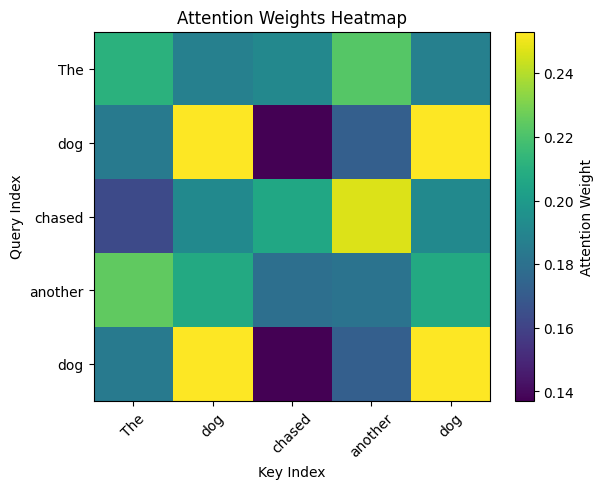

In [3]:
with torch.no_grad():
    attnOutput, attnWeights = mha(wQ(embeddedText), wK(embeddedText), wV(embeddedText))
print(attnOutput.shape)
print(attnWeights.shape)

import matplotlib.pyplot as plt

plt.imshow(attnWeights.detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Index')
plt.ylabel('Query Index')
plt.title('Attention Weights Heatmap')
plt.xticks(ticks=range(len(text.split())), labels=text.split(), rotation=45)
plt.yticks(ticks=range(len(text.split())), labels=text.split())
plt.show()

As you can see from the above attention heatmap, the columns 1 and 4 for "dog" are both the same because the term "dog" taken as a single out of context word has the same embedding and dot products regardless of where or when the operation was performed.

In [4]:
dog1 = attnOutput[1, :]
dog2 = attnOutput[4, :]
print(f"Attention outputs for both 'dog' entries are close: {torch.allclose(dog1, dog2, atol=1e-6)}")

dog1 = attnWeights[1, :]
dog2 = attnWeights[4, :]
print(f"Attention weights for both 'dog' entries are close: {torch.allclose(dog1, dog2, atol=1e-6)}")

Attention outputs for both 'dog' entries are close: True
Attention weights for both 'dog' entries are close: True


From an english speaker's perspective, "dog" in that sentence are completely different but from a maths perspective, they're are the same.
We need a way to encode the concept of a word having a different meaning depending on it's position in a sequence and this is exactly what **positional encoding** does!.

Positional encoding ensures that the term "dog" in the phrase "dog barks in the night, another dog hears the call, dogs in harmony." would take on an entirely different embedding so that they are treated differently during self attention, just like human languages would associate context to each "dog" occurrence.

## Desirable properties for a positional encoding scheme

1. Unique encoding for each position: A token should have a unique encoding regardless of the sequence length.
2. Linear relation between two encoded positions: It should be easy for the model to learn how a given position $p$, relates to a later position $p+k$. A simple scheme would the number line where it is obvious that 2 ($k$) positions after 3 ($p$) should be the position 5 ($p+k$).
3. It should be independent of the sequence length: This invariance to the sequence length is required so that the scheme can handle lengths outside what it was trained on.
4. The positioning scheme should be deterministic and learnable: related to #2. The model should be able learn how these encoding label position over any sequence length.
5. Support tokens in arbitrary dimensions i.e 1D sequences, 2D sequences or nD sequences: This is aimed at multi-modal models like Vision LLMs that can handle text and images sequences.

## Some position encoding schemes
### Integer position encoding
For each integer position of the token, this gets added to the values of the token.

<video alt="IntegerEncoding.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/IntegerEncoding.mp4" type="video/mp4">
  </video>


torch.Size([5, 128])
tensor([0.0062, 1.1038, 2.0171, 2.9889, 4.1038], grad_fn=<MeanBackward1>)
tensor([0, 1, 2, 3, 4])


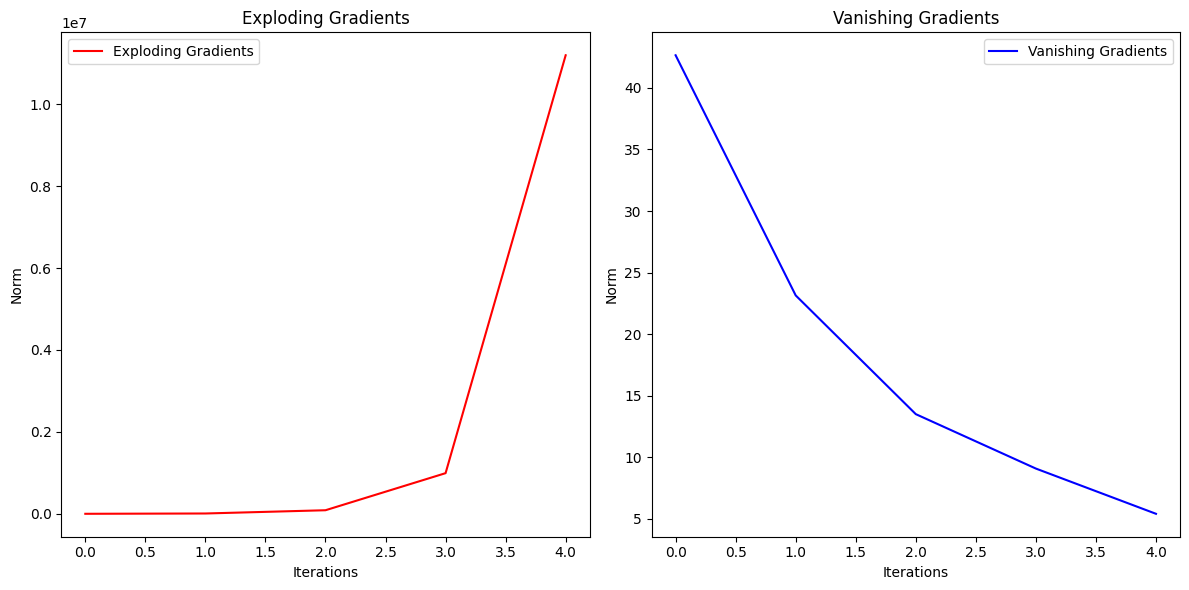

In [5]:
print(embeddedText.shape)
indexPositions = torch.arange(embeddedText.shape[0]).unsqueeze(1) # (5,1)
# Unsqueeze indexPositions to match the dimensions of embeddedText
positionalEncoding = embeddedText + indexPositions

row_means = positionalEncoding.mean(dim=1)
print(row_means)
print(indexPositions.squeeze())

exploding = []
vanishing = []
with torch.no_grad():
    p = positionalEncoding
    for _ in range(5):
        p = p @ torch.randn(128, 128)
        exploding.append(p.norm())

    p = positionalEncoding
    for _ in range(5):
        p = wQ(p)
        vanishing.append(p.norm())

plt.figure(figsize=(12, 6))

# Plot exploding gradients
plt.subplot(1, 2, 1)
plt.plot(exploding, label='Exploding Gradients', color='red')
plt.title('Exploding Gradients')
plt.xlabel('Iterations')
plt.ylabel('Norm')
plt.legend()

# Plot vanishing gradients
plt.subplot(1, 2, 2)
plt.plot(vanishing, label='Vanishing Gradients', color='blue')
plt.title('Vanishing Gradients')
plt.xlabel('Iterations')
plt.ylabel('Norm')
plt.legend()

plt.tight_layout()
plt.show()
        

In the above example, the final `positionalEncoding` have means that are similar to the index positions used in `indexPositions`.

This would obviously result in large values for long sequences which can lead to exploding gradients as illustrated. An obvious attempt would be to normalise it by the total tokens in the sequence as shown below.
However, this would violate the first requirement #1, as for example $0.8$ could be added to the token value at either the 5th position or the 100th position, and would depend heavily on the sequence length, which is not a desirable property - As #1 states that the encoded position should not depend on the sequence length.

In [6]:
indexPositions = torch.arange(embeddedText.shape[0]).unsqueeze(1) / embeddedText.shape[0] # (5,1)
# Unsqueeze indexPositions to match the dimensions of embeddedText
positionalEncoding = embeddedText + indexPositions

row_means = positionalEncoding.mean(dim=1)
print(row_means)
print(indexPositions.squeeze())

tensor([0.0062, 0.3038, 0.4171, 0.5889, 0.9038], grad_fn=<MeanBackward1>)
tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000])


### Binary position encoding

This is another valid scheme where the index positions are converted to their binary representation and added to the token values. 
This approach addresses the issues encountered with integer encoding by providing a more structured representation. However, it introduces a significant challenge: 
dimension mismatch. While this encoding can support arbitrary sequences, it does not inherently solve the problem of aligning the binary representation with the 
embedding dimension, which remains a critical limitation.

<video alt="BinaryEncoding.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="" style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryEncoding.mp4" type="video/mp4">
  </video>

<video alt="BinaryPositionalEncodingPlot.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="" style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryPositionalEncodingPlot.mp4" type="video/mp4">
  </video>

The binary encoding mechanism also results in discrete discontinuous values for each token which is not optimisation friendly
<video alt="BinaryVector3D.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="" style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryVector3D.mp4" type="video/mp4">
  </video>

### Sinusoidal position encoding

<figure style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
  <video alt="SteppedPositionalEncodingPlot.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/SteppedPositionalEncodingPlot.mp4" type="video/mp4">
  </video>
  <figcaption></figcaption>
</figure>





The authors wrote their function that generates frequency values that decay at the same rate regardless of the sequence length using the formula

$$
\omega_i = \frac{1}{10,000^{\frac{2i}{d}}}
$$

The base value of $10,000$ was chosen through experimentation. All it does is simply control the rate at which the plot decays, you can try this with different values of $10$, $100$, $1000$, $10000$ to see how it decays.

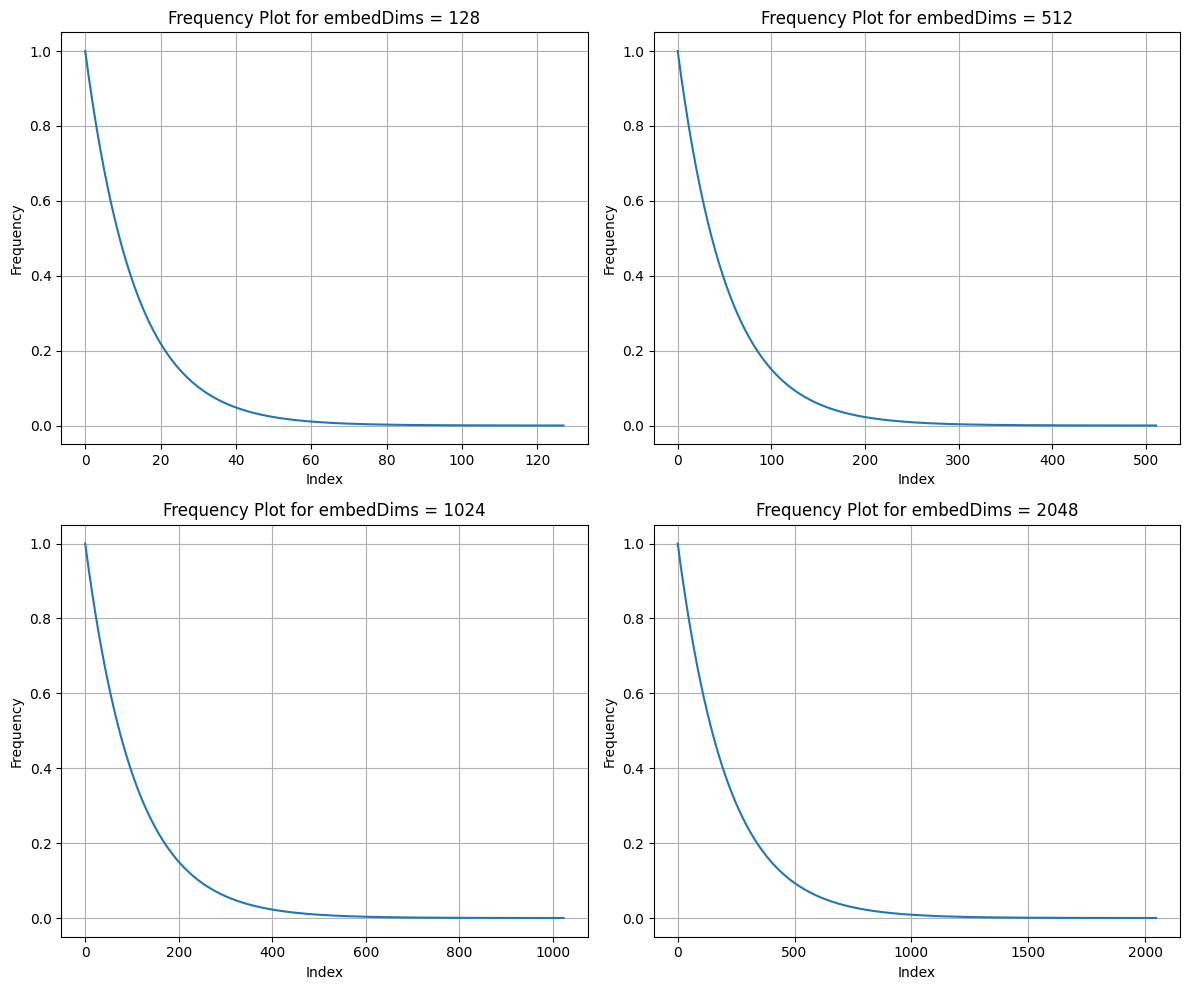

In [7]:
import ipywidgets as widgets
from ipywidgets import interact

def plot_frequency(baseWaveLength):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, embedDims in enumerate(embedDims_values):
        embedDimsIdx = torch.arange(0, embedDims)
        p = (2 * embedDimsIdx) / embedDims
        waveLength = torch.tensor(baseWaveLength)
        den = waveLength**p
        freq = 1 / den

        axes[i].plot(freq)
        axes[i].set_title(f'Frequency Plot for embedDims = {embedDims}')
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


embedDims_values = [128, 512, 1024, 2048]
plot_frequency(128)

In [8]:
# Create an interactive slider for baseWaveLength
interact(plot_frequency, baseWaveLength=widgets.IntSlider(min=5, max=10000, step=100, value=10000));

interactive(children=(IntSlider(value=10000, description='baseWaveLength', max=10000, min=5, step=100), Output…

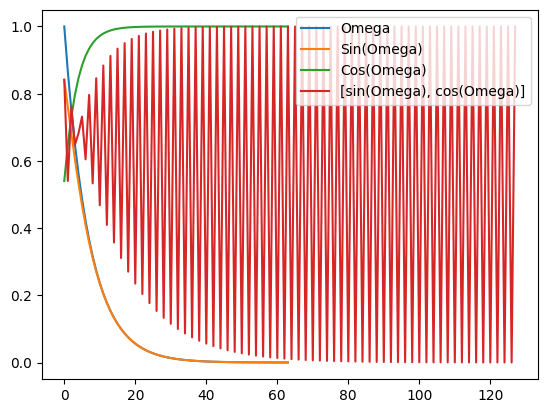

In [12]:
# Create a position matrix (each row corresponds to a token index)
positions = torch.arange(encodedText.numel()).unsqueeze(1)  # Shape: (N, 1)

# Compute frequency for each dimension
i = torch.arange(embedDims // 2)  # Half of the dimensions (because we pair sin and cos)
omega = 1 / (10000 ** (2 * i / embedDims))  # Shape: (d/2,)

plt.plot(omega, label='Omega')
plt.plot(torch.sin(omega), label='Sin(Omega)')
plt.plot(torch.cos(omega), label='Cos(Omega)')
xs = torch.zeros(1, embedDims)
xs[0, 0::2] = torch.sin(omega)
xs[0, 1::2] = torch.cos(omega)
plt.plot(xs.squeeze(), label='[sin(Omega), cos(Omega)]')
plt.legend(loc='upper right')


In [23]:
# Compute the sinusoidal encoding
positionalEncoding = torch.zeros((encodedText.numel(), embedDims))
positionalEncoding[:, 0::2] = torch.sin(positions * omega)  # Apply sin to even indices
positionalEncoding[:, 1::2] = torch.cos(positions * omega)  # Apply cos to odd indices

tokensPositionEncoded = embeddedText + positionalEncoding  # Element-wise addition

# Check the final shape
tokensPositionEncoded.shape

torch.Size([5, 128])